In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk #natural language toolkit
import seaborn as sns
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df = pd.read_csv('spam.csv',encoding = "ISO-8859-1")



# 1.Data Cleaning
# 2.EDA
# 3.Text Preprocessing
# 4.Model Building
## 5.Evaluation
# 6.Improvement


# ***Data Cleaning***

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
#drop columns
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)
#rename
df.rename(columns={'v1':'target','v2':'text'},inplace = True)



In [ ]:
df.head()



,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
#converting to malicious or non-malicious
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

df['target'] = encoder.fit_transform(df['target'])
df


,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [ ]:
#missing values
df.isnull().sum()


target    0
text      0
dtype: int64

In [ ]:
df.duplicated().sum()

403

In [ ]:
#remove duplicates
df = df.drop_duplicates(keep='first')
df.duplicated().sum()

0

# ***EDA***

In [ ]:
df['target'].value_counts()

0    4516
1     653
Name: target, dtype: int64

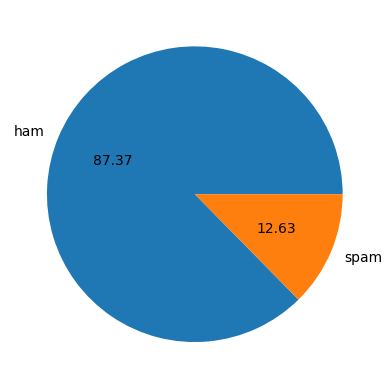

In [ ]:
plt.pie(df['target'].value_counts(),labels =['ham','spam'],autopct = '%0.2f')
plt.show()


<Axes: >

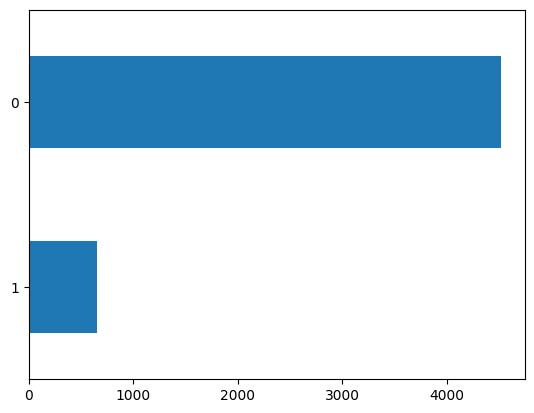

In [ ]:
df['target'].value_counts().sort_values().plot(kind = 'barh')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df['num_char'] = df['text'].apply(len)
df

<ipython-input-14-a11dbba3347d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_char'] = df['text'].apply(len)


,target,text,num_char
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161
5568,0,Will Ì_ b going to esplanade fr home?,37
5569,0,"Pity, * was in mood for that. So...any other s...",57
5570,0,The guy did some bitching but I acted like i'd...,125


In [ ]:
#num of words
df.loc[:,"num_words"] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df

<ipython-input-15-68725369b25a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"num_words"] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))


,target,text,num_char,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15
...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,35
5568,0,Will Ì_ b going to esplanade fr home?,37,9
5569,0,"Pity, * was in mood for that. So...any other s...",57,15
5570,0,The guy did some bitching but I acted like i'd...,125,27


In [ ]:
df.loc[:,'num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
df

<ipython-input-16-9b39f2c070d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))


,target,text,num_char,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1
...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,35,4
5568,0,Will Ì_ b going to esplanade fr home?,37,9,1
5569,0,"Pity, * was in mood for that. So...any other s...",57,15,2
5570,0,The guy did some bitching but I acted like i'd...,125,27,1


In [ ]:
df[['num_char','num_words','num_sentences']].describe()

,num_char,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [ ]:
df[df['target'] == 0][['num_char','num_words','num_sentences']].describe()

,num_char,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [ ]:
df[df['target'] == 1][['num_char','num_words','num_sentences']].describe()

,num_char,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


<Axes: xlabel='num_words', ylabel='Count'>

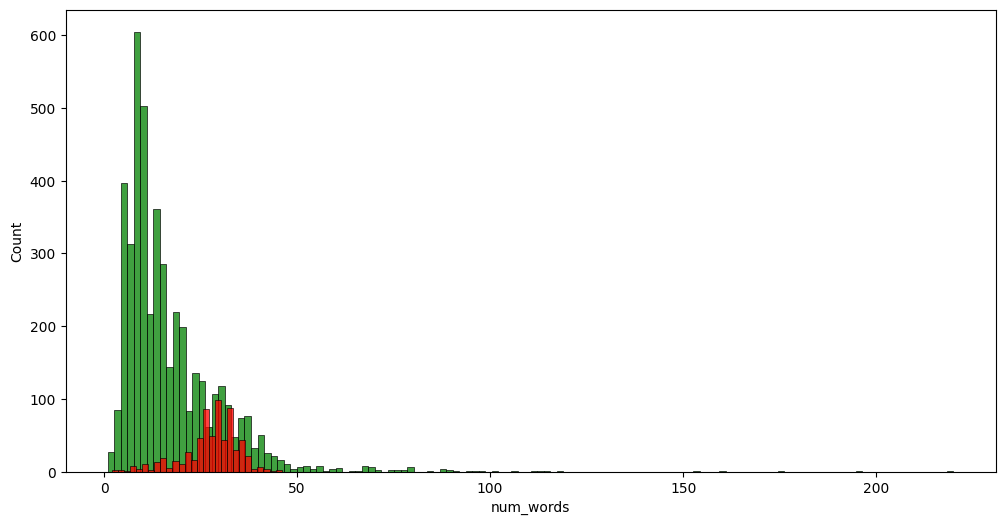

In [ ]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_words'],color='green')
sns.histplot(df[df['target'] == 1]['num_words'],color='red')

<Axes: xlabel='num_sentences', ylabel='Count'>

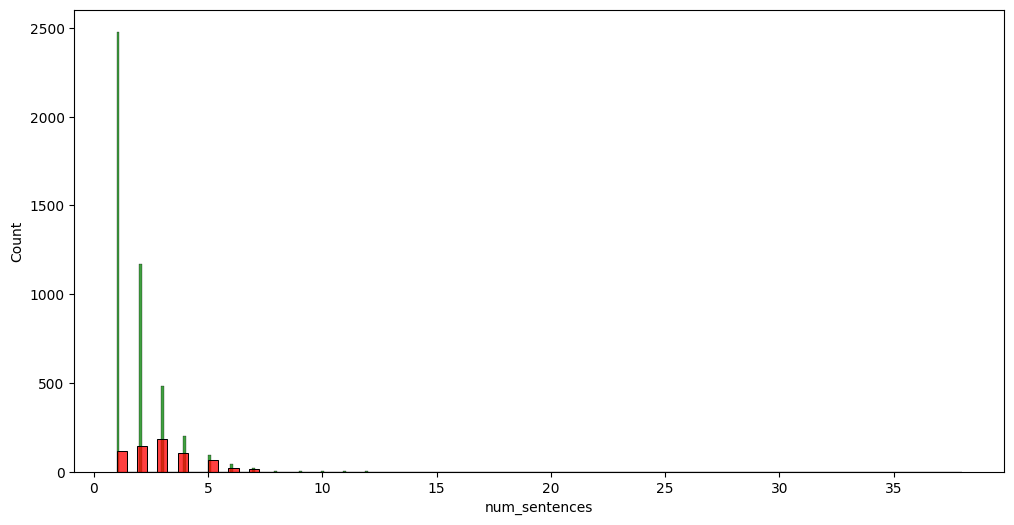

In [ ]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_sentences'],color='green')
sns.histplot(df[df['target'] == 1]['num_sentences'],color='red')

<Axes: xlabel='num_char', ylabel='Count'>

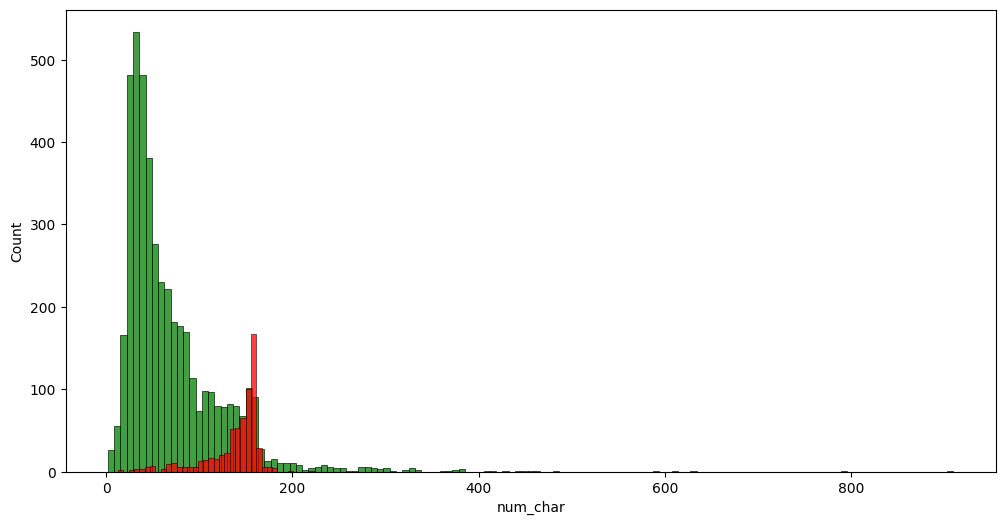

In [ ]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_char'],color='green')
sns.histplot(df[df['target'] == 1]['num_char'],color='red')

<Axes: title={'center': 'num_char'}, xlabel='target'>

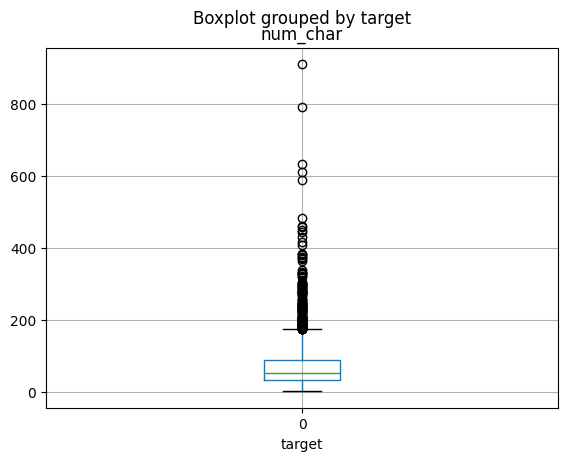

In [ ]:
ds = df[df['target'] == 0]
#box plot for not spam
ds.boxplot(by ='target', column =['num_char'], grid = True)


<Axes: xlabel='target', ylabel='num_char'>

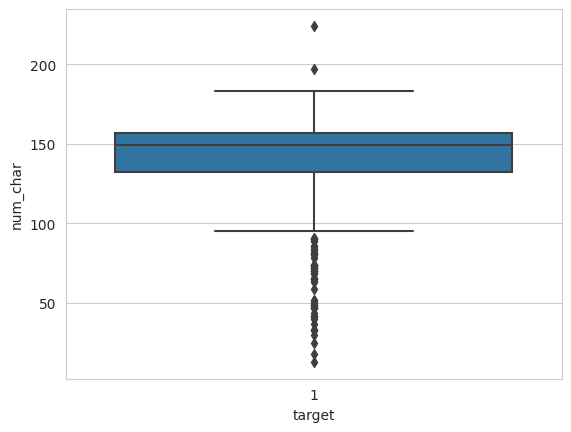

In [ ]:
ds = df[df['target'] == 1]
#box plot for spam using seaborn

sns.set_style("whitegrid")
sns.boxplot(x = 'target', y = 'num_char', data = ds)

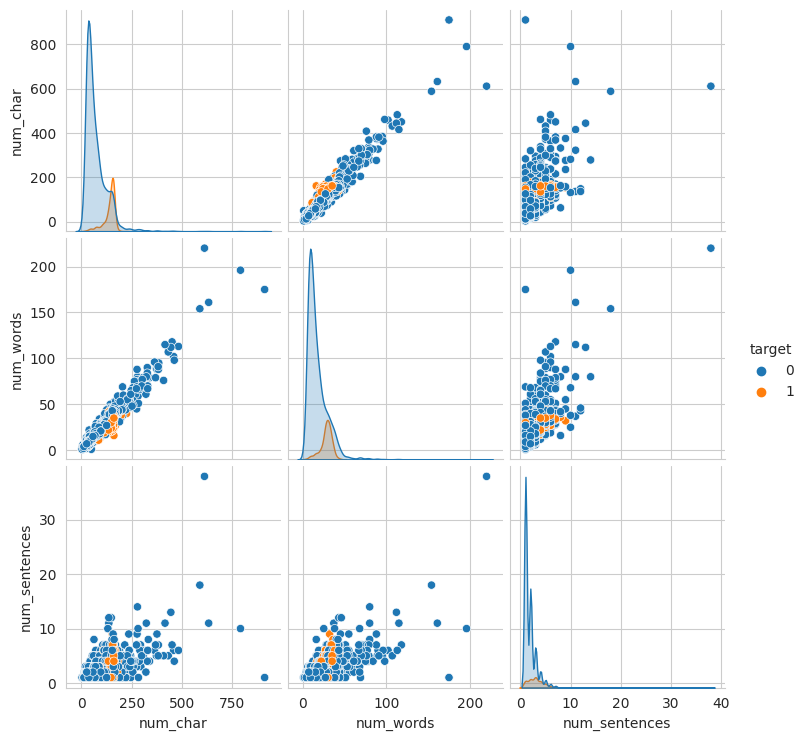

In [ ]:
sns.pairplot(df,hue='target')

<Axes: >

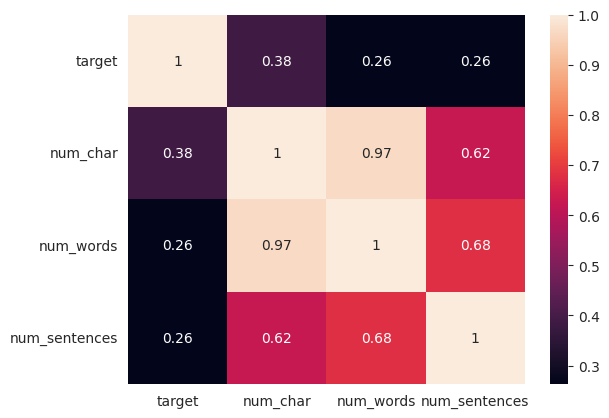

In [ ]:
sns.heatmap(df.corr(),annot=True)

# ***Data Preprocessing***


*   Lower Case

*   Tokenization
*  Removing characters


*   Removing stop words and punctuation


*  Stemming





In [ ]:
def transform_text(text):
  text = text.lower()
  text = nltk.word_tokenize(text)
  ps = PorterStemmer()
  y=[]
  for i in text:
    if i.isalnum():
      y.append(i)
  text = y[:]
  y.clear()
  for i in text:
    if i not in stopwords.words('english') and i not in string.punctuation:
      y.append(i)
  text = y[:]
  y.clear()
  for i in text:
    y.append(ps.stem(i))

  return " ".join(y)

In [ ]:

df['transformed_text'] = df['text'].apply(transform_text)
df

<ipython-input-28-7e91b1a85153>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transformed_text'] = df['text'].apply(transform_text)


,target,text,num_char,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though
...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,35,4,2nd time tri 2 contact u pound prize 2 claim e...
5568,0,Will Ì_ b going to esplanade fr home?,37,9,1,b go esplanad fr home
5569,0,"Pity, * was in mood for that. So...any other s...",57,15,2,piti mood suggest
5570,0,The guy did some bitching but I acted like i'd...,125,27,1,guy bitch act like interest buy someth els nex...


In [ ]:

#plt.scatter(df['transformed_text'] , y)

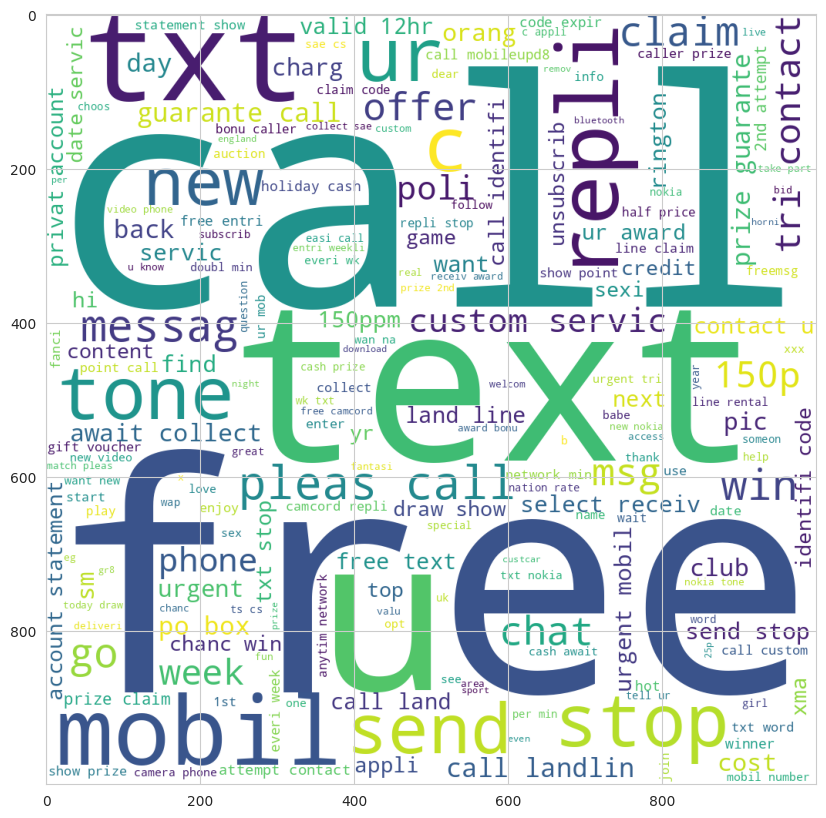

In [ ]:
wc = WordCloud(width=1000,height=1000,min_font_size = 10 ,background_color = 'white')
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(20,10))
plt.imshow(spam_wc)

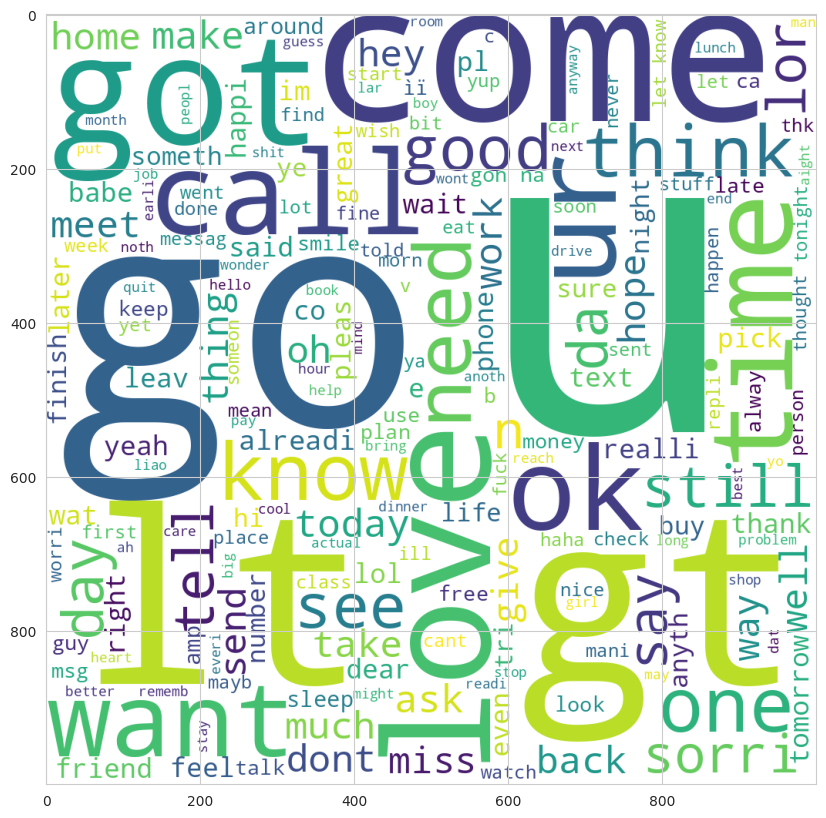

In [ ]:
wc = WordCloud(width=1000,height=1000,min_font_size = 10 ,background_color = 'white')
spam_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(20,10))
plt.imshow(spam_wc)

In [ ]:
spam_corpus=[]
for msg in df[df['target'] == 1]['transformed_text'].tolist():
  for word in msg.split():
   spam_corpus.append(word) #corpus collection of text


In [ ]:
ham_corpus=[]
for msg in df[df['target'] == 0]['transformed_text'].tolist():
  for word in msg.split():
   ham_corpus.append(word) #corpus collection of text

In [ ]:
len(spam_corpus)


9939

In [ ]:
len(ham_corpus)

35404

<Axes: xlabel='words', ylabel='count'>

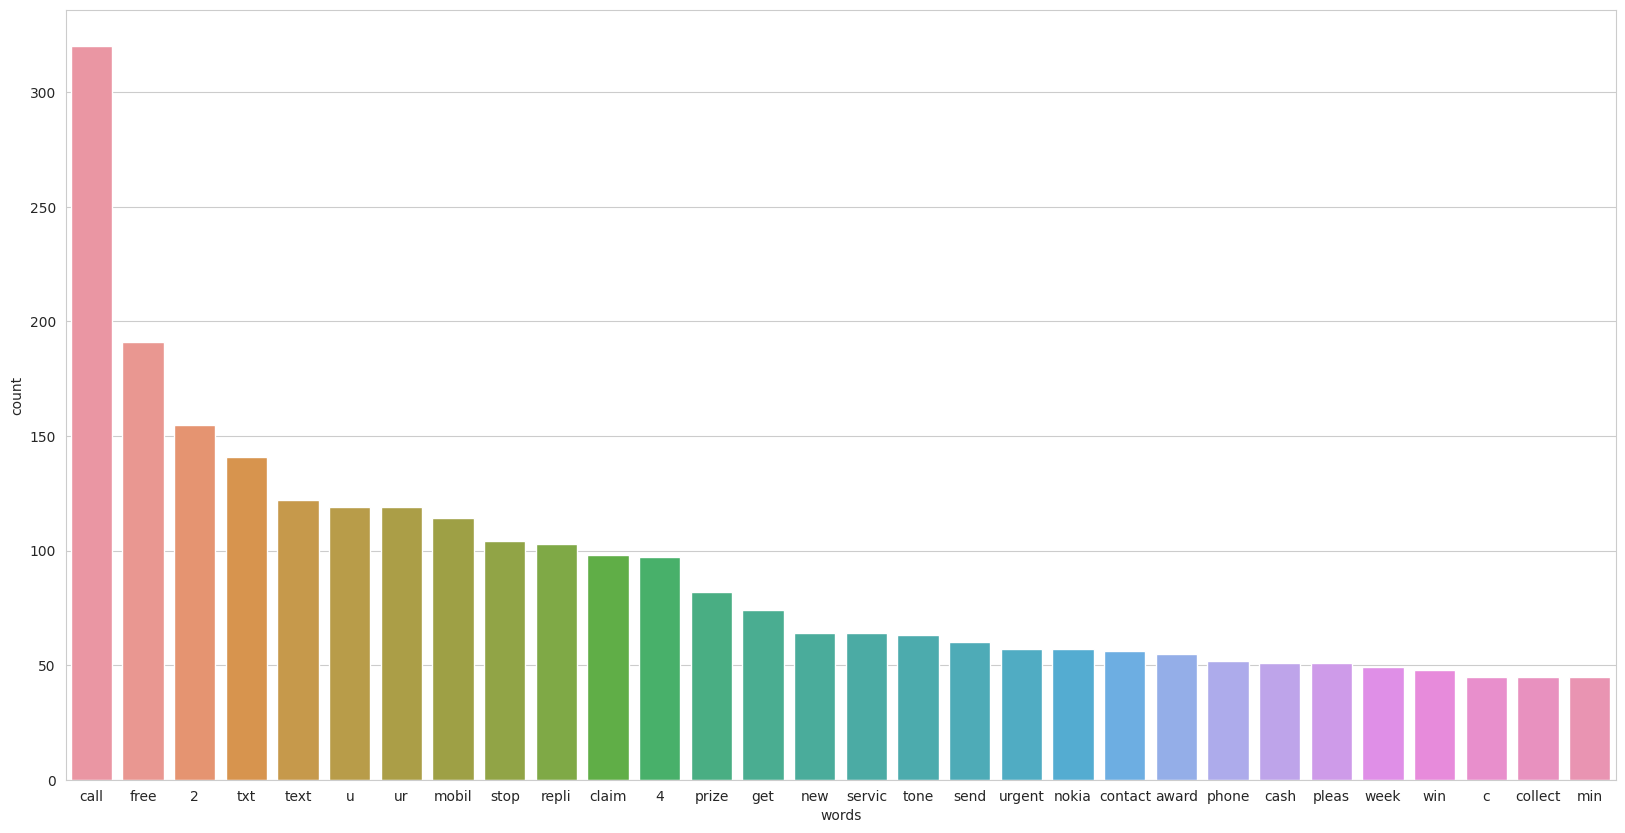

In [ ]:

dset = pd.DataFrame(Counter(spam_corpus).most_common(30))
plt.figure(figsize=(20,10))
dset.columns = ["words", "count"]
dset
sns.barplot(x = dset['words'],y = dset['count'])

<Axes: xlabel='words', ylabel='count'>

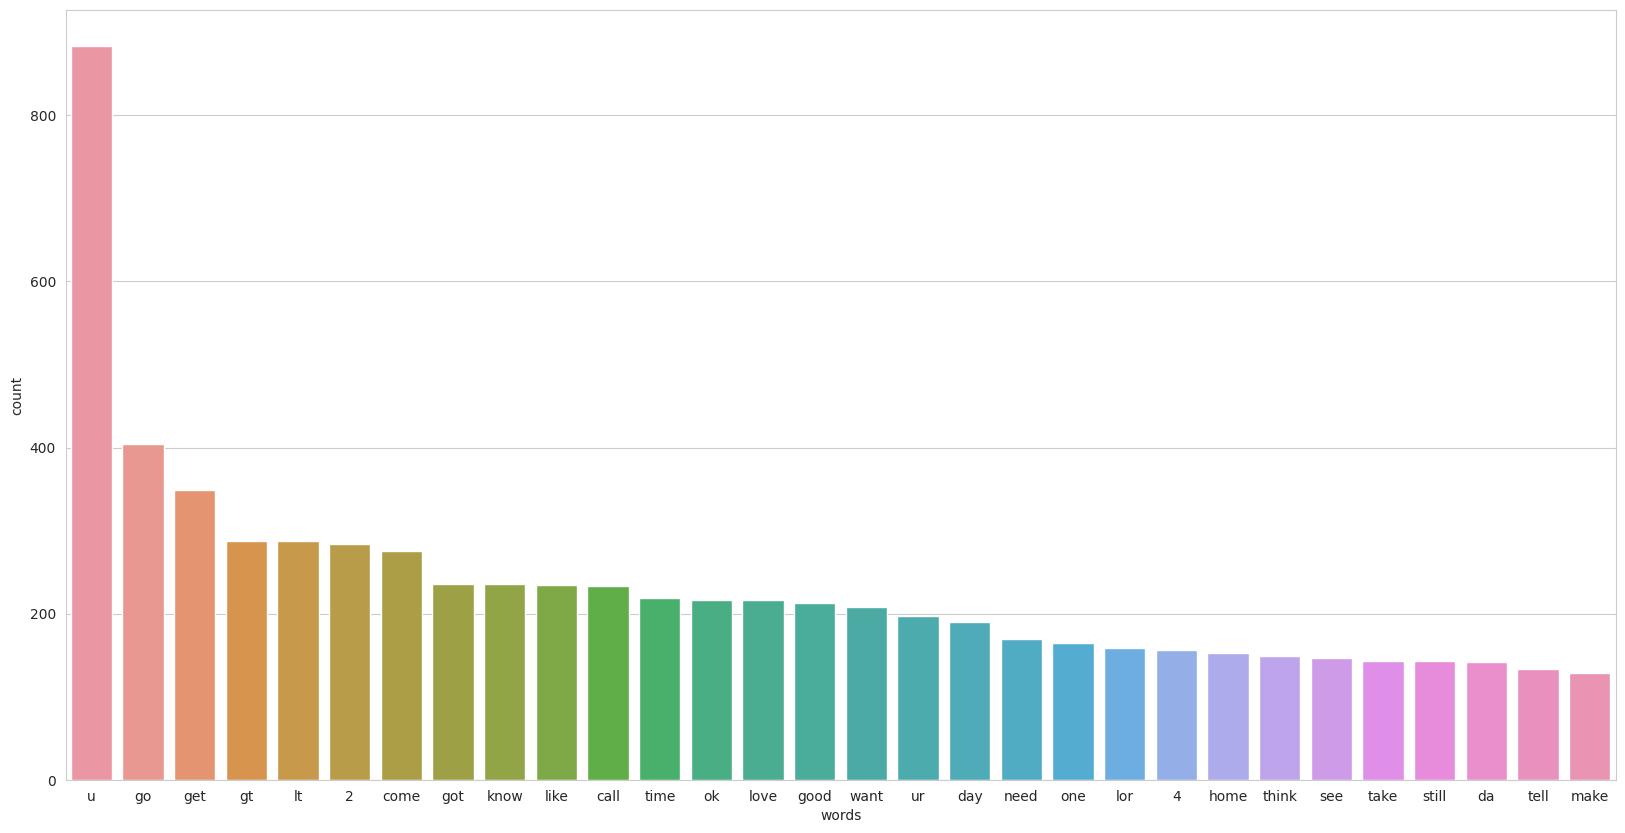

In [ ]:
dsetham = pd.DataFrame(Counter(ham_corpus).most_common(30))
plt.figure(figsize=(20,10))
dsetham.columns = ["words", "count"]
dset
sns.barplot(x = dsetham['words'],y = dsetham['count'])


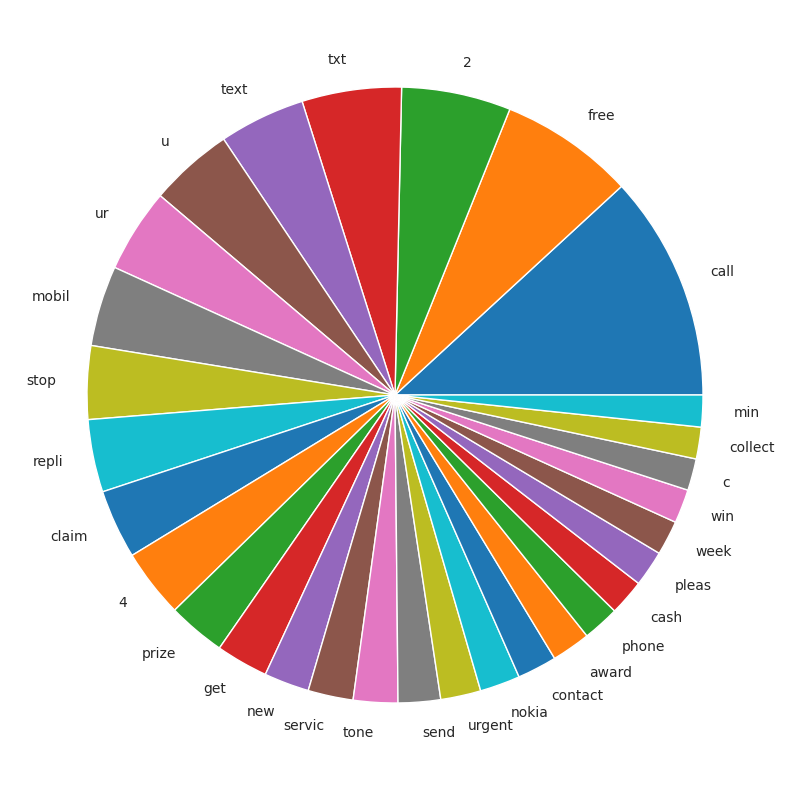

In [ ]:
plt.figure(figsize=(20,10))
plt.pie(dset['count'], labels = dset['words'])
plt.show()

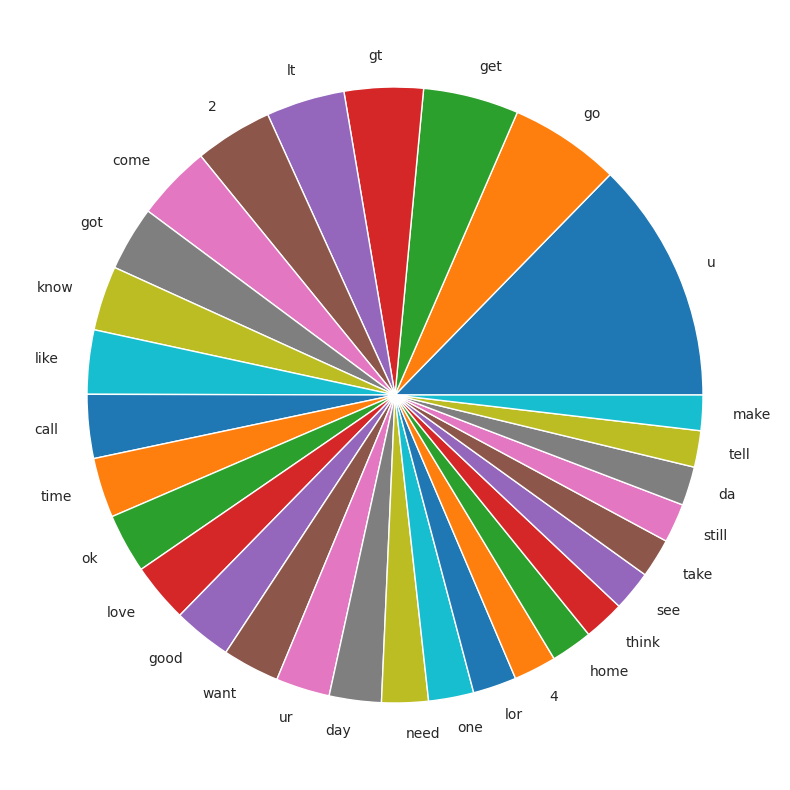

In [ ]:
plt.figure(figsize=(20,10))
plt.pie(dsetham['count'], labels =  dsetham['words'])
plt.show()


# ***Model Building***

In [ ]:
# cv = CountVectorizer()#CountVectorizer simply counts the number of times a word appears in a document (using a bag-of-words approach), while TF-IDF Vectorizer takes into account not only how many times a word appears in a document but also how important that word is to the whole corpus.
tfidf = TfidfVectorizer(max_features = 3000)#TfidfVectorizer - Transforms text to feature vectors that can be used as input to estimator. vocabulary_ Is a dictionary that converts each token (word) to feature index in the matrix, each unique token gets a feature index.
X  = tfidf.fit_transform(df['transformed_text']).toarray()


In [ ]:
X.shape

(5169, 3000)

In [ ]:
y = df['target'].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=2)


In [ ]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()


0.8694390715667312
[[788 108]
 [ 27 111]]
0.5068493150684932


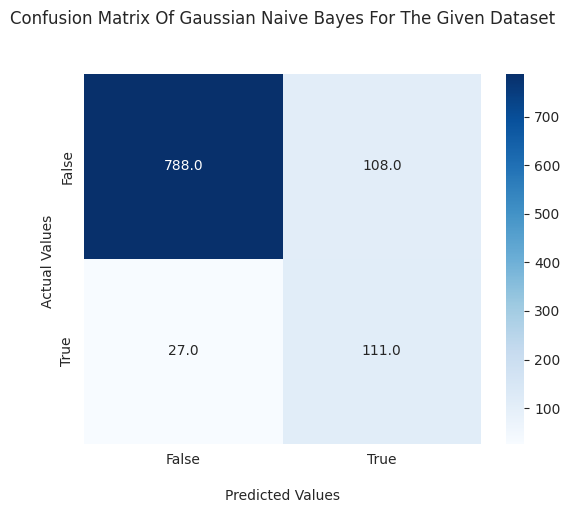

In [ ]:
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))#performance
print(precision_score(y_test,y_pred1))

cm=confusion_matrix(y_test,y_pred1)
import seaborn as sns

ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.1f')

ax.set_title('Confusion Matrix Of Gaussian Naive Bayes For The Given Dataset\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

0.9709864603481625
[[896   0]
 [ 30 108]]
1.0


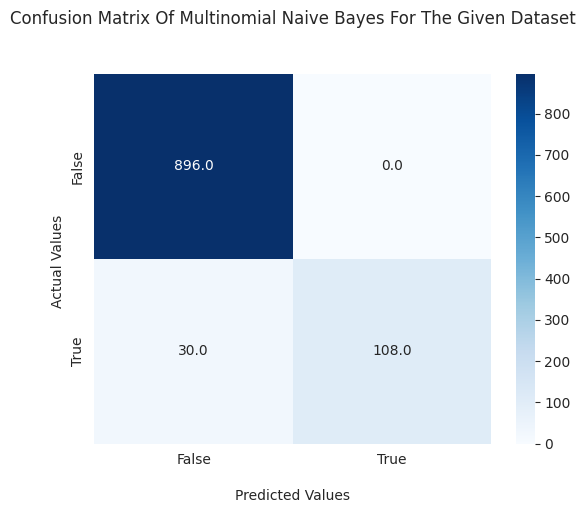

In [ ]:
mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))#performance
print(precision_score(y_test,y_pred2))

cm=confusion_matrix(y_test,y_pred2)
import seaborn as sns

ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.1f')

ax.set_title('Confusion Matrix Of Multinomial Naive Bayes For The Given Dataset\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

0.9835589941972921
[[895   1]
 [ 16 122]]
0.991869918699187


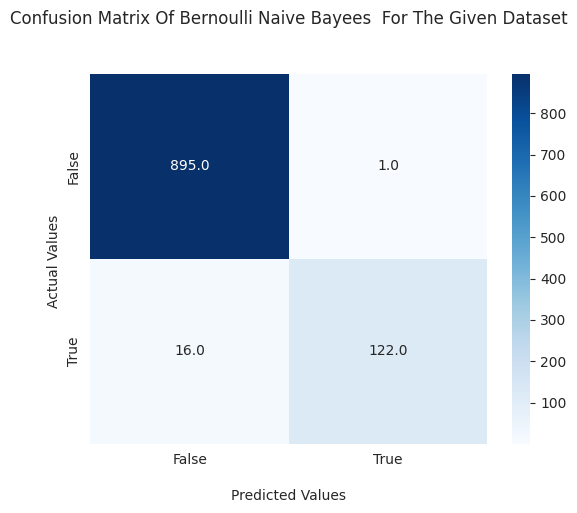

In [ ]:
bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))#performance
print(precision_score(y_test,y_pred3))

cm=confusion_matrix(y_test,y_pred3)
import seaborn as sns

ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.1f')

ax.set_title('Confusion Matrix Of Bernoulli Naive Bayees  For The Given Dataset\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

0.9671179883945842
[[888   8]
 [ 26 112]]
0.9333333333333333


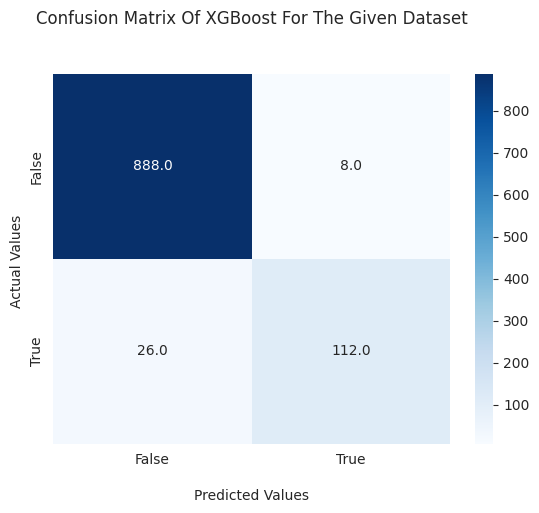

In [ ]:
xgb = XGBClassifier(n_estimators=50,random_state=2)
X  = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=2)
xgb.fit(X_train,y_train)
y_pred4 = xgb.predict(X_test)
print(accuracy_score(y_test,y_pred4))
print(confusion_matrix(y_test,y_pred4))#performance
print(precision_score(y_test,y_pred4))

cm=confusion_matrix(y_test,y_pred4)
import seaborn as sns

ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.1f')

ax.set_title('Confusion Matrix Of XGBoost For The Given Dataset\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

0.9748549323017408
[[894   2]
 [ 24 114]]
0.9827586206896551


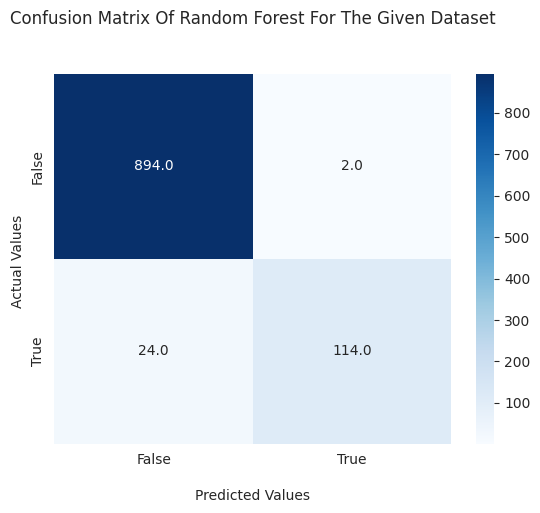

In [ ]:
clf = RandomForestClassifier(n_estimators = 100)#The n_estimators parameter specifies the number of trees in the forest of the model. The default value for this parameter is 10, which means that 10 different decision trees will be constructed in the random forest.
X  = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=2)
clf.fit(X_train,y_train)
y_pred5 = clf.predict(X_test)
print(accuracy_score(y_test,y_pred5))
print(confusion_matrix(y_test,y_pred5))#performance
print(precision_score(y_test,y_pred5))

cm=confusion_matrix(y_test,y_pred5)

import seaborn as sns

ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.1f')

ax.set_title('Confusion Matrix Of Random Forest For The Given Dataset\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier

0.941972920696325
[[1341   21]
 [  69  120]]
0.851063829787234


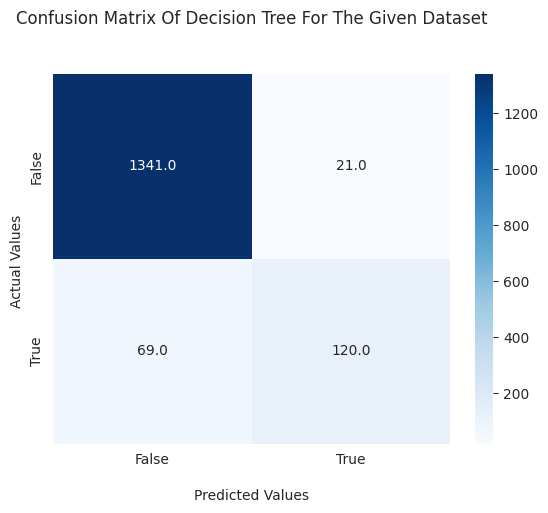

In [ ]:
X  = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=10, min_samples_leaf=8)
clf_gini.fit(X_train, y_train)
y_pred6 = clf_gini.predict(X_test)
cm=confusion_matrix(y_test,y_pred6)
print(accuracy_score(y_test,y_pred6))
print(confusion_matrix(y_test,y_pred6))#performance
print(precision_score(y_test,y_pred6))

import seaborn as sns

ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.1f')

ax.set_title('Confusion Matrix Of Decision Tree For The Given Dataset\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
 #Pickle is a useful Python tool that allows you to save your ML models, to minimise lengthy re-training and allow you to share, commit, and re-load pre-trained machine learning models. Most data scientists working in ML will use Pickle or Joblib to save their ML model for future use.
import pickle
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(clf,open('model.pkl','wb'))





In [ ]:

model=pickle.load(open('model.pkl','rb'))
tf=pickle.load(open('vectorizer.pkl','rb'))
message=input("Enter the text: ")
message_transformed=transform_text(message)

message_vector=tf.transform([message_transformed])

pred = model.predict(message_vector)[0]


if(pred==1):
   print("SPAM")
else:
   print("NOT SPAM")